In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:

# Function to download and prepare stock data
def get_stock_data(ticker, period='5y', interval='1d'):
    """
    Download stock data using yfinance
    
    Parameters:
    ticker (str): Stock ticker symbol
    period (str): Period to download ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    
    Returns:
    pandas.DataFrame: Processed stock data
    """
    
    stock = yf.Ticker(ticker)
    df = stock.history(period=period, interval=interval, auto_adjust=True)
    
    # Check if 'Close' column exists, if not try 'close' or create it from 'Adj Close'
    if 'Close' not in df.columns:
        if 'close' in df.columns:
            df['Close'] = df['close']
        elif 'Adj Close' in df.columns:
            df['Close'] = df['Adj Close']
        else:
            # If there's no close column at all, we'll use the last available price column
            price_cols = [col for col in df.columns if col in ['open', 'Open', 'high', 'High', 'low', 'Low']]
            if price_cols:
                df['Close'] = df[price_cols[0]]
            else:
                raise ValueError("Could not find a suitable price column in the data.")
    
    # Handle missing values safely
    df = df.ffill()  # Forward fill instead of using fillna(method='ffill')
    
    # Add some technical indicators
    # 1. Moving averages
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # 2. Relative Strength Index (RSI) - simplified version
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    # Avoid division by zero
    rs = gain / np.maximum(loss, 0.001)
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 3. MACD
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # 4. Price rate of change
    df['ROC'] = df['Close'].pct_change(periods=10) * 100
    
    # 5. Bollinger Bands
    df['20STD'] = df['Close'].rolling(window=20).std()
    df['Upper'] = df['MA20'] + (df['20STD'] * 2)
    df['Lower'] = df['MA20'] - (df['20STD'] * 2)
    
    # 6. Average True Range (ATR)
    # Ensure 'High' and 'Low' columns exist
    if 'High' not in df.columns and 'high' in df.columns:
        df['High'] = df['high']
    if 'Low' not in df.columns and 'low' in df.columns:
        df['Low'] = df['low']

    # Calculate ATR only if we have High and Low
    if 'High' in df.columns and 'Low' in df.columns:
        high_low = df['High'] - df['Low']
        high_close = np.abs(df['High'] - df['Close'].shift())
        low_close = np.abs(df['Low'] - df['Close'].shift())
        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = np.max(ranges, axis=1)
        df['ATR'] = true_range.rolling(14).mean()
    else:
        # Simple volatility measure as ATR fallback
        df['ATR'] = df['Close'].rolling(window=14).std()
    
    # 7. Volume Features (only if Volume column exists)
    if 'Volume' in df.columns:
        df['Volume_ROC'] = df['Volume'].pct_change(periods=1) * 100
        df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    else:
        # Create dummy volume features to maintain consistency
        df['Volume'] = 0
        df['Volume_ROC'] = 0
        df['Volume_MA20'] = 0
    
    # 8. Price momentum
    df['Momentum'] = df['Close'] - df['Close'].shift(10)
    
    # Drop NaN values
    df = df.dropna()
    
    # Prepare target variable (next day's closing price)
    df['Target'] = df['Close'].shift(-1)
    df = df.dropna()
    
    return df

# Function to prepare data for LSTM
def prepare_lstm_data(data, target_col='Target', look_back=60):
    """
    Prepare data for LSTM model
    
    Parameters:
    data (pandas.DataFrame): Input data
    target_col (str): Target column name
    look_back (int): Number of previous time steps to use as input features
    
    Returns:
    tuple: (X_train, y_train, X_test, y_test, scaler_X, scaler_y)
    """
    # Identify non-feature columns safely
    drop_cols = [col for col in ['Dividends', 'Stock Splits', 'target_col'] if col in data.columns]
    drop_cols.append(target_col)  # Add the actual target column
    
    # Separate features and target
    features = data.drop(drop_cols, axis=1, errors='ignore')
    target = data[target_col].values.reshape(-1, 1)
    
    # Scale the data
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    scaled_features = scaler_X.fit_transform(features)
    scaled_target = scaler_y.fit_transform(target)
    
    # Create sequences for LSTM
    X, y = [], []
    for i in range(look_back, len(scaled_features)):
        X.append(scaled_features[i-look_back:i, :])
        y.append(scaled_target[i, 0])
    
    X, y = np.array(X), np.array(y)
    
    # Split the data into training and testing sets (80% train, 20% test)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, y_train, X_test, y_test, scaler_X, scaler_y



In [19]:
# Function to build LSTM model
def build_lstm_model(input_shape):
    """
    Build an LSTM model for time series prediction
    
    Parameters:
    input_shape (tuple): Shape of input data (look_back, n_features)
    
    Returns:
    tensorflow.keras.models.Sequential: Compiled LSTM model
    """
    model = Sequential()
    
    # First LSTM layer with return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense layers
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model



In [20]:
# Function to train the model
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Train the LSTM model
    
    Parameters:
    model (tensorflow.keras.models.Sequential): LSTM model
    X_train, y_train, X_test, y_test: Training and testing data
    epochs (int): Number of epochs
    batch_size (int): Batch size
    
    Returns:
    tensorflow.keras.models.Sequential: Trained model
    """
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

# Function to make predictions
def make_predictions(model, X_test, scaler_y):
    """
    Make predictions using the trained model
    
    Parameters:
    model (tensorflow.keras.models.Sequential): Trained LSTM model
    X_test: Test data
    scaler_y: Scaler for target variable
    
    Returns:
    numpy.ndarray: Predicted values
    """
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform the predictions
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))
    
    return predictions

# Function to evaluate the model
def evaluate_model(y_test, predictions, scaler_y):
    """
    Evaluate the model performance
    
    Parameters:
    y_test: Actual test values
    predictions: Predicted values
    scaler_y: Scaler for target variable
    
    Returns:
    dict: Dictionary of evaluation metrics
    """
    # Inverse transform the actual values
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    mse = mean_squared_error(y_test_inv, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, predictions)
    
    # Percentage deviation
    deviation = np.abs(y_test_inv - predictions) / y_test_inv * 100
    mean_deviation = np.mean(deviation)
    
    # Direction accuracy (up/down)
    direction_actual = np.diff(y_test_inv.flatten())
    direction_pred = np.diff(predictions.flatten())
    direction_accuracy = np.mean((direction_actual > 0) == (direction_pred > 0)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Mean Percentage Deviation': mean_deviation,
        'Direction Accuracy': direction_accuracy
    }

# Function to plot results
def plot_predictions(y_test, predictions, scaler_y, ticker):
    """
    Plot actual vs predicted values
    
    Parameters:
    y_test: Actual test values
    predictions: Predicted values
    scaler_y: Scaler for target variable
    ticker: Stock ticker symbol
    """
    # Inverse transform the actual values
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to forecast future prices
def forecast_future(model, data, scaler_X, scaler_y, look_back, days_ahead=5):
    """
    Forecast future stock prices
    
    Parameters:
    model (tensorflow.keras.models.Sequential): Trained LSTM model
    data (pandas.DataFrame): Input data
    scaler_X: Scaler for features
    scaler_y: Scaler for target variable
    look_back (int): Number of previous time steps used as input features
    days_ahead (int): Number of days to forecast ahead
    
    Returns:
    numpy.ndarray: Forecasted prices
    """
    # Identify non-feature columns safely
    drop_cols = [col for col in ['Dividends', 'Stock Splits', 'Target'] if col in data.columns]
    
    # Get the last sequence of data
    features = data.drop(drop_cols, axis=1, errors='ignore')
    last_sequence = features.tail(look_back).values
    
    # Scale the sequence
    last_sequence = scaler_X.transform(last_sequence)
    
    # Reshape for LSTM input
    last_sequence = np.array([last_sequence])
    
    # Initialize the array to store predictions
    forecast = []
    
    # Make predictions for the specified number of days
    curr_seq = last_sequence.copy()
    for _ in range(days_ahead):
        # Predict the next day
        pred = model.predict(curr_seq)
        forecast.append(pred[0, 0])
        
        # Update the sequence for the next prediction
        # This is a simplified approach since we don't have all features for future days
        # In practice, you might want a more sophisticated approach to generate features
        new_seq = curr_seq[0, 1:, :]
        pred_feature = np.zeros((1, features.shape[1]))
        
        # Find index of 'Close' column
        try:
            close_idx = list(features.columns).index('Close')
        except ValueError:
            # If 'Close' is not found, use the first column as a fallback
            close_idx = 0
        
        pred_feature[0, close_idx] = pred[0, 0]  # Set the predicted close price
        new_seq = np.vstack([new_seq, pred_feature])
        curr_seq = np.array([new_seq])
    
    # Inverse transform the predictions
    forecast = np.array(forecast).reshape(-1, 1)
    forecast = scaler_y.inverse_transform(forecast)
    
    return forecast

# Main function to run the entire pipeline
def stock_prediction_pipeline(ticker, period='2y', interval='1d', look_back=60, forecast_days=3):
    """
    Run the entire stock prediction pipeline
    
    Parameters:
    ticker (str): Stock ticker symbol
    period (str): Period of historical data
    interval (str): Interval of data
    look_back (int): Number of previous time steps to use
    forecast_days (int): Number of days to forecast ahead
    
    Returns:
    dict: Dictionary containing model, evaluation metrics, and forecast
    """
    print(f"Starting prediction pipeline for {ticker}...")
    
    # Get data
    print("Downloading and preparing stock data...")
    data = get_stock_data(ticker, period, interval)
    print(f"Downloaded {len(data)} data points")
    
    # Prepare data
    print("Preparing LSTM data...")
    X_train, y_train, X_test, y_test, scaler_X, scaler_y = prepare_lstm_data(data, look_back=look_back)
    print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")
    
    # Build and train model
    print("Building and training LSTM model...")
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)
    model, history = train_model(model, X_train, y_train, X_test, y_test)
    
    # Make predictions
    print("Making predictions...")
    predictions = make_predictions(model, X_test, scaler_y)
    
    # Evaluate model
    print("Evaluating model performance...")
    metrics = evaluate_model(y_test, predictions, scaler_y)
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Plot results
    plot_predictions(y_test, predictions, scaler_y, ticker)
    
    # Forecast future prices
    print(f"Forecasting prices for next {forecast_days} days...")
    forecast = forecast_future(model, data, scaler_X, scaler_y, look_back, forecast_days)
    
    # Get the last closing price
    last_price = data['Close'].iloc[-1]
    
    # Calculate the date range for the forecast
    last_date = data.index[-1]
    date_range = []
    for i in range(1, forecast_days + 1):
        # Skip weekends
        next_date = last_date + timedelta(days=i)
        while next_date.weekday() > 4:  # Skip Saturday (5) and Sunday (6)
            next_date = next_date + timedelta(days=1)
        date_range.append(next_date)
    
    # Display forecast
    print("\nForecasted Prices:")
    for i, (date, price) in enumerate(zip(date_range, forecast)):
        change = (price[0] - last_price) / last_price * 100 if i == 0 else (price[0] - forecast[i-1][0]) / forecast[i-1][0] * 100
        print(f"{date.strftime('%Y-%m-%d')}: ${price[0]:.2f} (Change: {change:.2f}%)")
    
    return {
        'model': model,
        'metrics': metrics,
        'forecast': forecast,
        'forecast_dates': date_range,
        'data': data,
        'last_price': last_price
    }

Starting prediction pipeline for NVDA...
Downloaded 453 data points
Preparing LSTM data...
Training data shape: (314, 60, 20), Testing data shape: (79, 60, 20)
Building and training LSTM model...
Epoch 1/50


/Users/anshugusain/hackillinois/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.1693 - val_loss: 0.0132
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0231 - val_loss: 0.0047
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0143 - val_loss: 0.0100
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0099 - val_loss: 0.0070
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0079 - val_loss: 0.0033
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0077 - val_loss: 0.0053
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061 - val_l

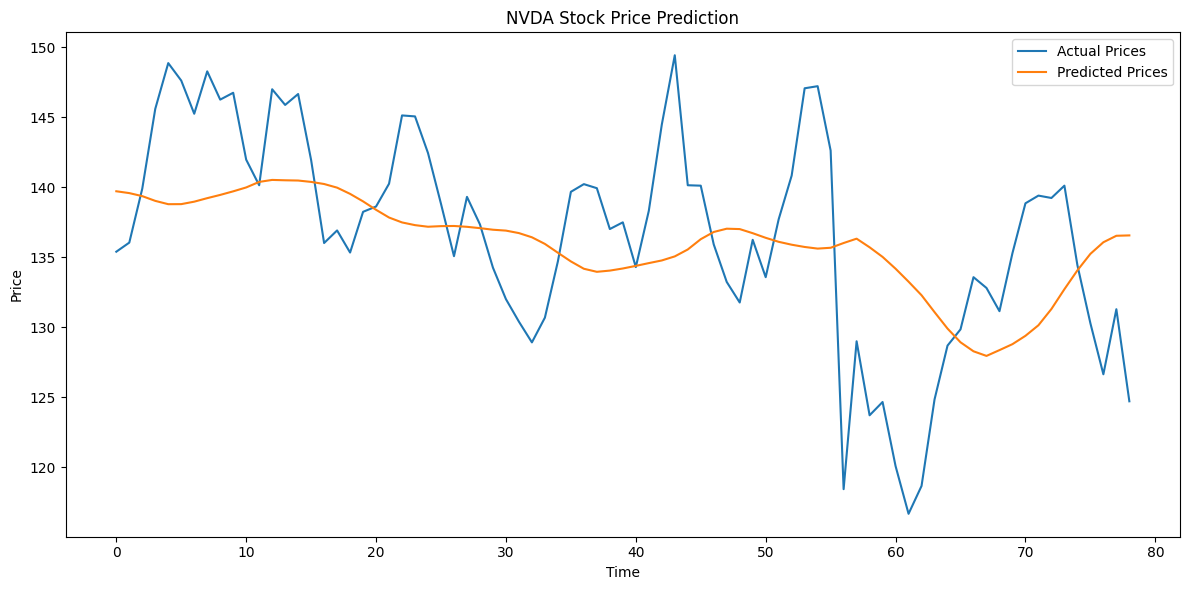

Forecasting prices for next 3 days...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Forecasted Prices:
2025-02-27: $136.54 (Change: 4.00%)
2025-02-28: $133.72 (Change: -2.06%)
2025-03-03: $128.99 (Change: -3.54%)

Prediction Summary:
Model Direction Accuracy: 39.74%
Mean Percentage Deviation: 4.21%


/Users/anshugusain/hackillinois/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


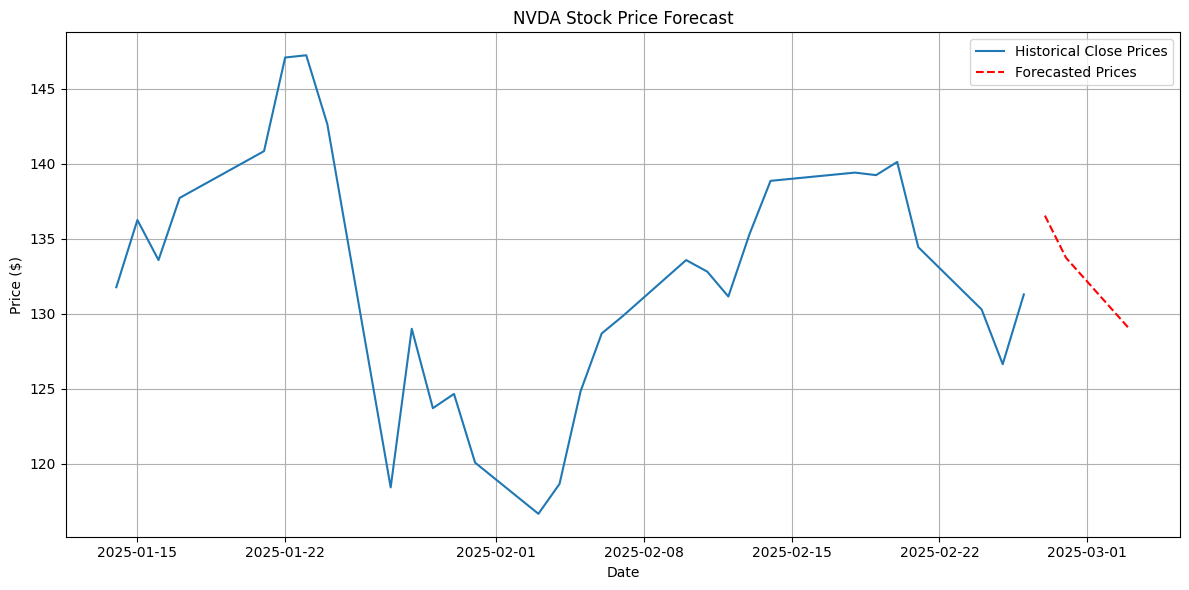

In [23]:
# Example usage
if __name__ == "__main__":
    # Set the ticker symbol
    ticker = 'NVDA'
    
    # Run the prediction pipeline
    results = stock_prediction_pipeline(ticker=ticker, forecast_days=3)
    
    # Print a summary
    print("\nPrediction Summary:")
    print(f"Model Direction Accuracy: {results['metrics']['Direction Accuracy']:.2f}%")
    print(f"Mean Percentage Deviation: {results['metrics']['Mean Percentage Deviation']:.2f}%")
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    
    # Plot historical data (last 30 days)
    historical = results['data'].tail(30)
    plt.plot(historical.index, historical['Close'], label='Historical Close Prices')
    
    # Plot forecast
    forecast_dates = results['forecast_dates']
    forecast_prices = [price[0] for price in results['forecast']]
    plt.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
results['model'].save('stock_prediction_model.keras')